"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
#https://discourse.pymc.io/t/nuts-uses-all-cores/909/9


import os
os.environ["MKL_NUM_THREADS"]='1'
os.environ["OMP_NUM_THREADS"]='1'

In [2]:
base_dir = '/media/bigdata/projects/pytau'
import sys
sys.path.append(base_dir)
import pytau.changepoint_model as models

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Using directory: /media/bigdata/projects/pytau//pytau/how_to/examples/saved_models


In [3]:
import pickle
import scipy.stats as stats
import pymc as pm
import pytensor.tensor as tt
import numpy as np
import pylab as plt
import arviz as az
import pandas as pd
import seaborn as sns

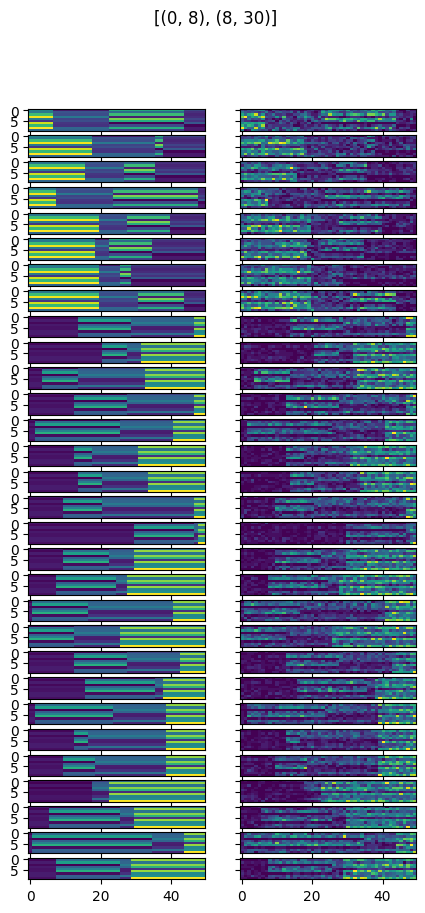

In [4]:
# Some poisson spiking
length = 50
states = 4
nrns = 10
trial_count = 30
idx = np.arange(length)
rate_scaler = 20
trial_switches = 2


def gen_lambda():
    lambda_multipliers = np.random.random(states) * rate_scaler
    true_lambda = np.random.random((nrns,states))
    true_lambda = true_lambda * lambda_multipliers[np.newaxis,:]
    return true_lambda

def return_trial_dat(true_lambda):
    true_tau = np.cumsum(np.random.random(states))
    true_tau /= np.max(true_tau)
    true_tau *= length
    true_tau = np.vectorize(int)(true_tau)
    state_inds = np.concatenate([np.zeros((1)),true_tau])
    state_inds = np.vectorize(int)(state_inds)
    true_tau = true_tau[:-1]

    true_r = np.zeros((nrns,length))
    for num, val in enumerate(true_lambda.T):
        true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]

    #data_array = np.random.random(true_r.shape) < true_r
    data_array = np.random.poisson(true_r)
    return true_r, data_array

def return_poisson_data():
    true_lambda = gen_lambda()
    trial_list = [return_trial_dat(true_lambda) for i in range(trial_count)]
    r_list, spike_list = list(zip(*trial_list))
    r_array, spike_array = np.stack(r_list), np.stack(spike_list)
    return r_array, spike_array

def return_poisson_data_switch(n_trial_states = 2):
    trial_fracs = np.cumsum(np.random.random(n_trial_states))
    trial_fracs = trial_fracs / trial_fracs.max()
    trial_inds = np.vectorize(int)(trial_fracs * trial_count)
    trial_inds = np.concatenate([[0], trial_inds])
    trial_sections = [(trial_inds[i], trial_inds[i+1]) for i in range(len(trial_inds)-1)]
    r_array_list = []
    spike_array_list = []
    for this_section in trial_sections:
        true_lambda = gen_lambda()
        trial_list = [return_trial_dat(true_lambda) for i in range(trial_count)]
        r_list, spike_list = list(zip(*trial_list))
        r_array, spike_array = np.stack(r_list), np.stack(spike_list)
        r_array_list.append(r_array[this_section[0]:this_section[1]])
        spike_array_list.append(spike_array[this_section[0]:this_section[1]])
    fin_r_array = np.concatenate(r_array_list, axis = 0)
    fin_spike_array = np.concatenate(spike_array_list, axis = 0)
    return fin_r_array, fin_spike_array, trial_sections

r_array, spike_array, trial_sections = return_poisson_data_switch(trial_switches)

fig, ax = plt.subplots(trial_count,2, 
                       sharex=True, sharey=True,
                      figsize = (5,10))
fig.suptitle(trial_sections)

for i in range(trial_count):
    ax[i,0].imshow(r_array[i],aspect='auto', interpolation='nearest');
    ax[i,1].imshow(spike_array[i],aspect='auto', interpolation='nearest');

In [5]:
# ! cat /media/bigdata/projects/pytau/pytau/changepoint_model.py

In [6]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate(
        [[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [7]:
switch_components = 3

trial_num, nrn_num, time_bins = spike_array.shape

with pm.Model() as model:

        # Define Emissions

        # nrns
        nrn_lambda = pm.Exponential('nrn_lambda', 10, shape=(nrn_num))

        # nrns x switch_comps
        trial_lambda = pm.Exponential('trial_lambda',
                                      nrn_lambda.dimshuffle(0, 'x'),
                                      shape=(nrn_num, switch_components))

        # nrns x switch_comps x states
        state_lambda = pm.Exponential('state_lambda',
                                      trial_lambda.dimshuffle(0, 1, 'x'),
                                      shape=(nrn_num, switch_components, states))
        # Define Changepoints
        # Assuming distribution of changepoints remains
        # the same across all trials

        a = pm.HalfCauchy('a_tau', 3., shape=states - 1)
        b = pm.HalfCauchy('b_tau', 3., shape=states - 1)

        even_switches = np.linspace(0, 1, states+1)[1:-1]
        tau_latent = pm.Beta('tau_latent', a, b,
                             # testval=even_switches,
                             shape=(trial_num, states-1)).sort(axis=-1)

        # Trials x Changepoints
        tau = pm.Deterministic('tau', time_bins * tau_latent)

        # Define trial switches
        # Will have same structure as regular changepoints

        # even_trial_switches = np.linspace(0, 1, switch_components+1)[1:-1]
        # tau_trial_latent = pm.Beta('tau_trial_latent', 1, 1,
        #                           # testval=even_trial_switches,
        #                           shape=(switch_components-1)).sort(axis=-1)

In [8]:
with model:
        # Hyperpriors on alpha
        a_gamma = pm.Gamma('a_gamma', 10, 1)
        b_gamma = pm.Gamma('b_gamma', 1.5, 1)

        # Concentration parameter for beta
        alpha = pm.Gamma('alpha', a_gamma, b_gamma)

        # Draw beta's to calculate stick lengths
        beta = pm.Beta('beta', 1, alpha, shape=switch_components)

        # Calculate stick lengths using stick_breaking process
        w_raw = pm.Deterministic('w_raw', stick_breaking(beta))

        # Make sure lengths add to 1, and scale to length of data
        tau_trial_latent = pm.Deterministic('w_latent', tt.cumsum(w_raw / w_raw.sum())[:-1])
        # w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
        # tau = pm.Deterministic('tau', tt.cumsum(w_latent * length)[:-1])

In [9]:
with model:
        # Trial_changepoints
        tau_trial = pm.Deterministic('tau_trial', trial_num * tau_trial_latent)

        trial_idx = np.arange(trial_num)
        trial_selector = tt.math.sigmoid(
            trial_idx[np.newaxis, :] - tau_trial.dimshuffle(0, 'x'))

        trial_selector = tt.concatenate(
            [np.ones((1, trial_num)), trial_selector], axis=0)
        inverse_trial_selector = 1 - trial_selector[1:, :]
        inverse_trial_selector = tt.concatenate([inverse_trial_selector,
                                                np.ones((1, trial_num))], axis=0)

        # First, we can "select" sets of emissions depending on trial_changepoints
        # switch_comps x trials
        trial_selector = np.multiply(trial_selector, inverse_trial_selector)

        # state_lambda: nrns x switch_comps x states

        # selected_trial_lambda : nrns x states x trials
        selected_trial_lambda = pm.Deterministic('selected_trial_lambda',
                                                 tt.sum(
                                                     # "nrns" x switch_comps x "states" x trials
                                                     trial_selector.dimshuffle(
                                                         'x', 0, 'x', 1) * state_lambda.dimshuffle(0, 1, 2, 'x'),
                                                     axis=1)
                                                 )

        # Then, we can select state_emissions for every trial
        idx = np.arange(time_bins)

        # tau : Trials x Changepoints
        weight_stack = tt.math.sigmoid(
            idx[np.newaxis, :]-tau[:, :, np.newaxis])
        weight_stack = tt.concatenate(
            [np.ones((trial_num, 1, time_bins)), weight_stack], axis=1)
        inverse_stack = 1 - weight_stack[:, 1:]
        inverse_stack = tt.concatenate(
            [inverse_stack, np.ones((trial_num, 1, time_bins))], axis=1)

        # Trials x states x Time
        weight_stack = np.multiply(weight_stack, inverse_stack)

        # Convert selected_trial_lambda : nrns x trials x states x "time"

        # nrns x trials x time
        lambda_ = tt.sum(selected_trial_lambda.dimshuffle(0, 2, 1, 'x') * weight_stack.dimshuffle('x', 0, 1, 2),
                         axis=2)

        # Convert to : trials x nrns x time
        lambda_ = lambda_.dimshuffle(1, 0, 2)

        # Add observations
        observation = pm.Poisson("obs", lambda_, observed=spike_array)

In [ ]:
n_chains = 24
dpp_trace = models.dpp_fit(model, n_cores = int(np.min([n_chains, 24])), 
                           n_chains = n_chains, use_numpyro=True,
                          tune = 125, draws = 125)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

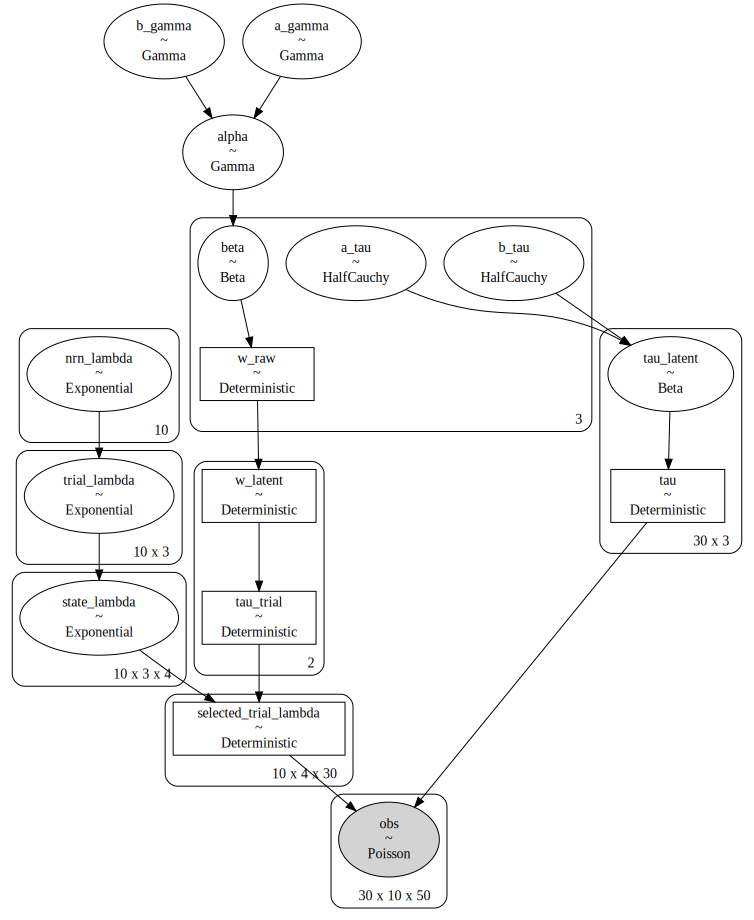

In [10]:
pm.model_to_graphviz(model)

In [ ]:
tau_trial_samples = dpp_trace.posterior['tau_trial'].values
plt.hist(tau_trial_samples.flatten(), bins = 50);

In [ ]:
with model:
    ppc_samples = pm.sample_posterior_predictive(dpp_trace, extend_inferencedata=False)

In [ ]:
mean_ppc = ppc_samples.posterior_predictive.obs.values.mean(axis=(0,1))

In [ ]:
fig, ax = plt.subplots(trial_count,3, 
                       sharex=True, sharey=True,
                      figsize = (5,20))

for i in range(trial_count):
    ax[i,0].imshow(r_array[i],aspect='auto', interpolation='nearest');
    ax[i,1].imshow(spike_array[i],aspect='auto', interpolation='nearest');
    ax[i,2].imshow(mean_ppc[i],aspect='auto', interpolation='nearest');

In [54]:
def single_taste_poisson_dpp_trial_switch(
        spike_array,
        switch_components,
        states):
    """
    Assuming only emissions change across trials
    Changepoint distribution remains constant

    spike_array :: trials x nrns x time
    states :: number of states to include in the model 
    """

    

    

        





    return model

IndentationError: unexpected indent (2415591747.py, line 22)

In [ ]:

def stick_breaking_trial(this_beta, trial_count):
    portion_remaining = tt.concatenate(
        [
            np.ones((trial_count, 1)),
            tt.extra_ops.cumprod(1 - this_beta, axis=-1)[:, :-1]
        ],
        axis=-1)
    return this_beta * portion_remaining



def single_taste_poisson_dirichlet(
        spike_array,
        max_states=10,
        **kwargs):
    """
    Model for changepoint on single taste using dirichlet process prior

    Args:
        spike_array (3D Numpy array): trials x neurons x time
        max_states (int): Maximum number of states to model

    Returns:
        pymc3 model: Model class containing graph to run inference on
    """
    mean_vals = np.array([np.mean(x, axis=-1)
                          for x in np.array_split(spike_array, max_states, axis=-1)]).T
    mean_vals = np.mean(mean_vals, axis=1)
    mean_vals += 0.01  # To avoid zero starting prob

    nrns = spike_array.shape[1]
    trials = spike_array.shape[0]
    idx = np.arange(spike_array.shape[-1])
    length = idx.max() + 1

    with pm.Model() as model:
        # ===================
        # Emissions Variables
        # ===================
        lambda_latent = pm.Exponential('lambda',
                                       1/mean_vals,
                                       shape=(nrns, max_states))

        # =====================
        # Changepoint Variables
        # =====================

        # Hyperpriors on alpha
        a_gamma = pm.Gamma('a_gamma', 10, 1)
        b_gamma = pm.Gamma('b_gamma', 1.5, 1)

        # Concentration parameter for beta
        alpha = pm.Gamma('alpha', a_gamma, b_gamma)

        # Draw beta's to calculate stick lengths
        beta = pm.Beta('beta', 1, alpha, shape=(trials, max_states))

        # Calculate stick lengths using stick_breaking process
        w_raw = pm.Deterministic('w_raw', stick_breaking_trial(beta, trials))

        # Make sure lengths add to 1, and scale to length of data
        w_latent = pm.Deterministic(
            'w_latent', w_raw / w_raw.sum(axis=-1)[:, None])
        tau = pm.Deterministic('tau', tt.cumsum(
            w_latent * length, axis=-1)[:, :-1])

        # =====================
        # Rate over time
        # =====================

        # Weight stack to assign lambda's to point in time
        weight_stack = tt.math.sigmoid(
            idx[np.newaxis, :]-tau[:, :, np.newaxis])
        weight_stack = tt.concatenate(
            [np.ones((trials, 1, length)), weight_stack], axis=1)
        inverse_stack = 1 - weight_stack[:, 1:]
        inverse_stack = tt.concatenate(
            [inverse_stack, np.ones((trials, 1, length))], axis=1)
        # Trials x States x Time
        weight_stack = np.multiply(weight_stack, inverse_stack)

        lambda_ = pm.Deterministic('lambda_',
            tt.tensordot(weight_stack, lambda_latent, [1, 1]).swapaxes(1, 2))

        # =====================
        # Likelihood
        # =====================
        observation = pm.Poisson("obs", lambda_, observed=spike_array)

    return model

In [5]:
max_states = 10
dpp_model = models.single_taste_poisson_dirichlet(spike_array, max_states = max_states)

In [6]:
n_chains = 24
dpp_trace = models.dpp_fit(dpp_model, n_cores = 24, n_chains = n_chains, use_numpyro=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

2024-09-15 15:30:02.177763: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce = f64[24,500,8,10]{3,2,1,0} reduce(f64[24,500,1,8,10]{4,3,2,1,0} %broadcast.12, f64[] %constant.18), dimensions={2}, to_apply=%region_2.56, metadata={op_name="jit(process_fn)/jit(main)/reduce_prod[axes=(2,)]" source_file="/tmp/tmp_ak4bzii" source_line=29}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-09-15 15:30:03.749769: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.572177494s
Constant folding an instruction is taking > 1s:

  %reduce = f64[24,500,8,10]{3,2,1,0

In [8]:
dpp_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [10]:
tau_samples = dpp_trace.posterior['tau']
w_latent_samples = dpp_trace.posterior['w_latent']

In [14]:
w_latent_samples.shape

(24, 500, 8, 10)

TypeError: Invalid shape (12000, 8, 10) for image data

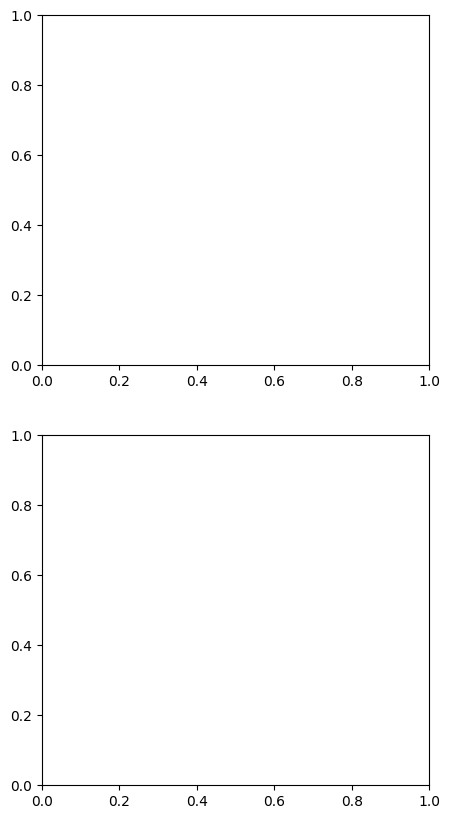

In [11]:
cat_w_latent_samples = np.concatenate(w_latent_samples)
sorted_lens = np.sort(cat_w_latent_samples,axis=-1)[:,::-1]

fig,ax = plt.subplots(2,1, figsize=(5,10))
im1 = ax[0].imshow(sorted_lens, interpolation='nearest', aspect= 'auto')
im2 = ax[1].imshow(cat_w_latent_samples, interpolation='nearest', aspect= 'auto')
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_title('Sorted')
ax[1].set_title('Unsorted')
plt.tight_layout()

In [15]:
mean_chain_w_latent = np.stack(np.array_split(w_latent_samples,n_chains,axis=0)).mean(axis=1)
sorted_state_durations = np.sort(mean_chain_w_latent,axis=-1)[...,::-1]
mean_chain_w_latent.shape

(24, 500, 8, 10)

ValueError: x and y can be no greater than 2D, but have shapes (10,) and (10, 8, 500)

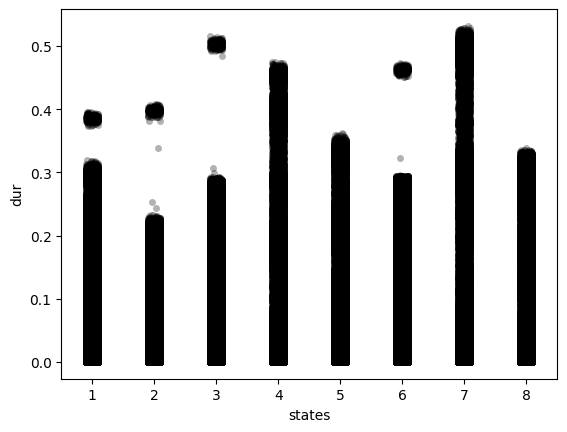

In [16]:
inds = np.array(list(np.ndindex(sorted_state_durations.shape)))
state_frame = pd.DataFrame(
                        dict(
                            chains = inds[:,0],
                            trials = inds[:,1],
                            states = inds[:,2]+1,
                            dur = sorted_state_durations.flatten()
                        )
                    )

sns.stripplot(
    data = state_frame,
    x = 'states',
    y = 'dur',
    color = 'k',
    alpha = 0.3,
)
plt.plot(sorted_state_durations.mean(axis=0).T, alpha = 0.7, color = 'grey');

In [28]:
dur_thresh = 0.1
state_count = (mean_chain_w_latent > dur_thresh).sum(axis=-1)

No handles with labels found to put in legend.


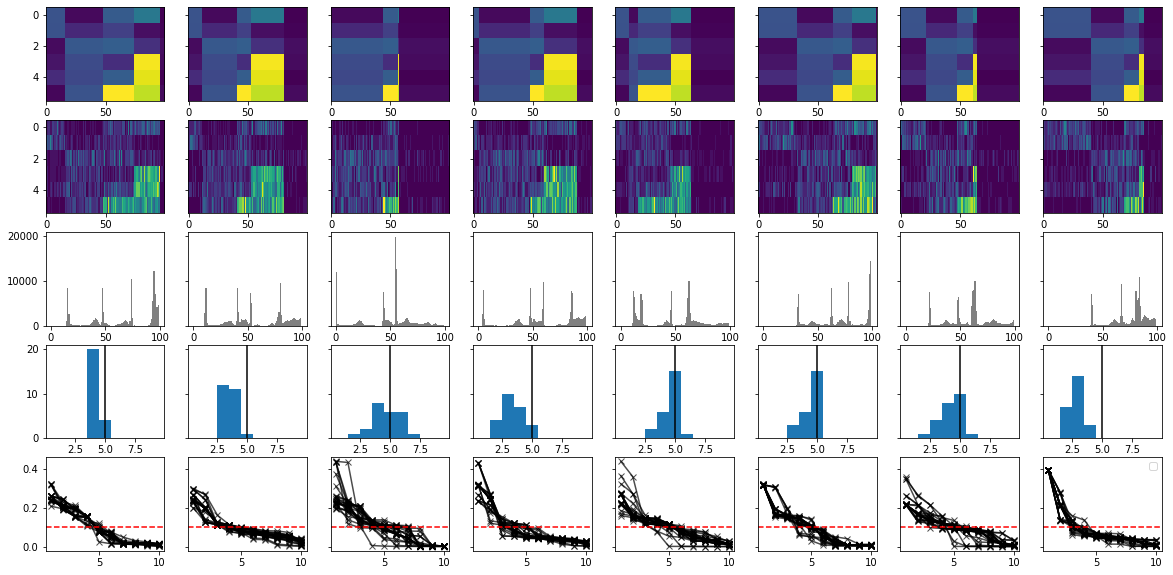

In [29]:
fig, ax = plt.subplots(5,trial_count, 
                       sharex='row',sharey='row',
                      figsize = (20,10))

for i in range(trial_count):
    ax[0,i].imshow(r_array[i],aspect='auto', interpolation='nearest');
    ax[1,i].imshow(spike_array[i],aspect='auto', interpolation='nearest');
    ax[2,i].hist(tau_samples[:,i].flatten(), bins = idx, color = 'grey');
    ax[3,i].hist(state_count[:,i], bins = np.arange(max_states)+0.5)
    ax[3,i].axvline(states, color = 'k', label = 'Actual States');
    ax[4,i].plot(np.arange(max_states)+1, sorted_state_durations[:,i].T, '-x', alpha = 0.7, color = 'k');
    ax[4,i].axhline(dur_thresh, color = 'red', linestyle = '--');
plt.legend()

In [30]:
mode_states = np.stack([stats.mode(state_count[:,i])[0] for i in range(trial_count)]).flatten()

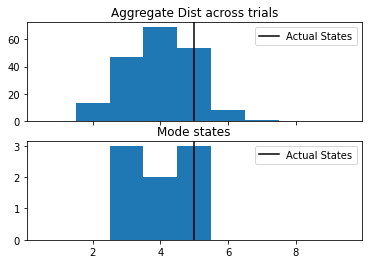

In [31]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].hist(state_count.flatten(), bins = np.arange(max_states)+0.5);
ax[0].axvline(states, color = 'k', label = 'Actual States');
ax[0].legend();
ax[0].set_title('Aggregate Dist across trials');
ax[1].hist(mode_states, bins = np.arange(max_states)+0.5);
ax[1].axvline(states, color = 'k', label = 'Actual States');
ax[1].legend();
ax[1].set_title('Mode states');